# Convolutional Autoencoder (CAE)
### Authors: Sergi Nogués and Gilles Salem

This is the second assignment for ACML at the MSc in
Artificial Intelligence at Maastricht University.

[Source code](https://github.com/serginogues/convolutional_autoencoder)

CIFAR-10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import torch
from torchvision import datasets
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_PATH = 'D:/UM/ACML/Assignments/'
VALIDATION_SIZE = 0.1  # percentage of the training set used for validation
TRAIN_SIZE = 0.8
TEST_SIZE = 0.1
BATCH_SIZE = 64
# Compatibility with CUDA and GPU -> remember to move into GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


_Divide your dataset into training (80%), validation (10%) and test (10%). Normalize the data:_

Files already downloaded and verified
Files already downloaded and verified
image label: truck
torch.Size([3, 32, 32])


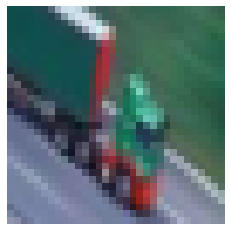


# samples train set = 48000
# samples test set = 6000
# samples validation set = 6000
Sample distribution: 80% train, 10% test, 10% validation


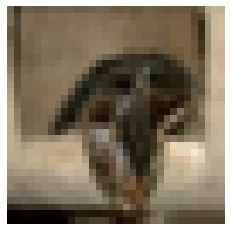

In [3]:
train_dataset = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())
classes = train_dataset.classes

img, label = train_dataset[50]
print("image label:", classes[label])

# since we already used the transform, type(img) = torch.Tensor
print(img.shape)

# plot with original axis before converting PIL Image to Tensor, otherwise an Exception arises
# C × H × W to H × W × C
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

concat_dataset = ConcatDataset([train_dataset, test_dataset])
len_ = len(concat_dataset)
train_set, test_set, valid_set = random_split(concat_dataset, [round(len_ * TRAIN_SIZE), round(len_ * TEST_SIZE), round(len_ * VALIDATION_SIZE)])

print("")
print("# samples train set =", len(train_set))
print("# samples test set =", len(test_set))
print("# samples validation set =", len(valid_set))
total_samp = len(train_set) + len(test_set) + len(valid_set)
print("Sample distribution: " + str(round((len(train_set) / total_samp) * 100))
      + "% train, " + str(round((len(test_set) / total_samp) * 100)) + "% test, "
      + str(round((len(valid_set) / total_samp) * 100)) + "% validation")

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

Xs, Ys = iter(train_loader).next()
images = Xs.numpy()
images = images
plt.imshow(np.transpose(images[30], (1, 2, 0)))
plt.axis('off')
plt.show()

_Implement the autoencoder network specified above. Run the training for at least 10 epochs, and plot the
evolution of the error with epochs._

In [4]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


In [5]:
class CAE(nn.Module):
    def __init__(self, channels, padding = 1, stride = 1, kernel = 3):
        super(CAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels[0], kernel_size=kernel, padding=padding, stride=stride)
        self.conv2 = nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=kernel, padding=padding, stride=stride)
        self.conv3 = nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=kernel, padding=padding, stride=stride)
        self.maxpool = nn.MaxPool2d(kernel_size=kernel-1, stride=stride, padding=0)

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=channels[2], out_channels=channels[3], kernel_size=kernel+1, padding=padding, stride=stride)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=channels[3], out_channels=3, kernel_size=kernel+1, padding=padding, stride=stride)
        self.print_latent_shape = 0

    def forward(self, x):
        # encoder
        x1 = F.relu(self.conv1(x))

        x2 = self.maxpool(x1)
        x3 = F.relu(self.conv2(x2))
        x4 = self.maxpool(x3)
        x5 = F.relu(self.conv3(x4))

        # decoder
        x6 = F.relu(self.t_conv1(x5))
        y = F.sigmoid(self.t_conv2(x6))

        if self.print_latent_shape == 0:
            print(str(x1.shape) + " -> " + str(x2.shape) + " -> " + str(x3.shape) + " -> ")
            print(str(x4.shape) + " -> Latent space:" + str(x5.shape) + " -> " + str(x6.shape) + " -> " + str(y.shape))
            self.print_latent_shape +=1

        return y

In [6]:
from tqdm import tqdm
EPOCHS = 10
SAVE_PATH = 'models/cae.pth'
SAVE_PATH2 = 'models/cae2.pth'
SAVE_PATH3 = 'models/cae3.pth'
TRAIN = True
LR = 0.01
channels = [8, 12, 16, 12]

model = CAE(channels=channels).to(device)
criterion = nn.BCELoss()  # loss function
#optimizer = optim.SGD(model.parameters(), lr=LR)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

C:\Users\nogue\.virtualenvs\sergi_env\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([64, 8, 32, 32]) -> torch.Size([64, 8, 31, 31]) -> torch.Size([64, 12, 31, 31]) -> 
torch.Size([64, 12, 30, 30]) -> Latent space:torch.Size([64, 16, 30, 30]) -> torch.Size([64, 12, 31, 31]) -> torch.Size([64, 3, 32, 32])
Epoch 0, Loss = 0.5688736982643516
Epoch 1, Loss = 0.5565238985313756
Epoch 2, Loss = 0.5546628838451266
Epoch 3, Loss = 0.553524699599466
Epoch 4, Loss = 0.5530301735647527
Epoch 5, Loss = 0.5526905206942591
Epoch 6, Loss = 0.5527404539385846
Epoch 7, Loss = 0.5522915887850472
Epoch 8, Loss = 0.5521489986648863
Epoch 9, Loss = 0.5519313751668893
Training finished


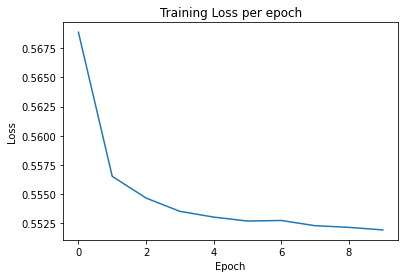

In [7]:
def train(model, save=SAVE_PATH):
    loss_history = []
    running_loss = 0.0
    for i in range(EPOCHS):
        # TRAIN MODEL
        loss_sum = 0
        n = 0
        for j, data in enumerate(train_loader, 0):
            n = j
            # get the training data
            images, label = data
            images = images.to(device)

            # Before the backward pass, set gradients to zero
            optimizer.zero_grad()

            # predict
            output = model.forward(images)

            # compute loss
            loss = criterion(output, images)
            loss_sum += round(float(loss.item()), 4)

            # backpropagate loss error
            loss.backward()

            # optimize with backprop
            optimizer.step()
            del data, images, label

        # region print current loss
        loss_epoch = loss_sum/n
        loss_history.append(loss_epoch)
        print("Epoch "+ str(i) +", Loss = "+ str(loss_epoch))

    # SAVE THE MODEL
    torch.save(model.state_dict(), save)
    print("Training finished")

    # PLOT ACCURACY
    plt.plot(loss_history)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training Loss per epoch')
    plt.show()

train(model)

_Report also the test error._

In [8]:
def load_model(path = SAVE_PATH):
    model = CAE(channels)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def test(trained_model):
    with torch.no_grad():
        loss_sum = 0
        n = 0
        for images, labels in test_loader:
            output = trained_model.forward(images)
            loss = criterion(output, images)
            loss_sum += round(float(loss.item()), 4)
            n += 1
        loss_final = loss_sum/n
        print("Test Loss = ", loss_final)

trained_model = load_model(SAVE_PATH)
test(trained_model)

torch.Size([64, 8, 32, 32]) -> torch.Size([64, 8, 31, 31]) -> torch.Size([64, 12, 31, 31]) -> 
torch.Size([64, 12, 30, 30]) -> Latent space:torch.Size([64, 16, 30, 30]) -> torch.Size([64, 12, 31, 31]) -> torch.Size([64, 3, 32, 32])
Test Loss =  0.5519904255319148


We now test our trained model with these 5 images:

<ipython-input-9-9863a18850b2>:8: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


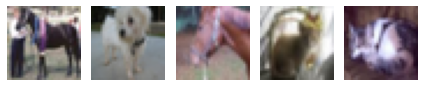

In [9]:
images, labels = iter(test_loader).next()
images_plot = images.numpy()

ff, axarr = plt.subplots(1, 5, constrained_layout=True)
for i in range(5):
    axarr[i].imshow(np.transpose(images_plot[i], (1, 2, 0)))
    axarr[i].axis('off')
plt.tight_layout()
plt.show()

After 10 epochs of training our model does a good reconstruction:

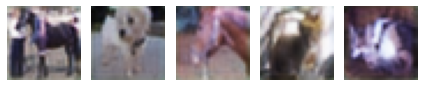

In [10]:
# Sample outputs
output = trained_model.forward(images)
output = output.detach().numpy()

ff2, axarr = plt.subplots(1, 5)
for i in range(5):
    axarr[i].imshow(np.transpose(output[i], (1, 2, 0)))
    axarr[i].axis('off')
plt.tight_layout()
plt.show()

_What is the size of the latent space representation of the above network?_

conv filter formula: $W' = \frac{W - K + 2P}{S} + 1$

Encoder:
1. out_conv1 = batch_size x 8 x 32 x 32 where $32 = 32 - 3 + 2 + 1$
- out_pool1 = batch_size x 8 x 31 x 31
- out_conv2 = batch_size x 12 x 31 x 31
- out_pool2 = batch_size x 12 x 30 x 30
- out_conv3 = batch_size x 16 x 30 x 30

Latent space size = 16 x 30 x 30 = 14400

_Try other architectures (e.g. fewer intermediate layers, different number of channels, filter sizes or stride and
padding configurations) to answer questions such as: What is the impact of those in the reconstruction error
after training? Is there an obvious correlation between the size of the latent space representation and the error?_

torch.Size([64, 5, 16, 16]) -> 
torch.Size([64, 5, 15, 15]) -> 
torch.Size([64, 8, 8, 8]) -> 
torch.Size([64, 8, 7, 7]) -> 
Latent space shape: torch.Size([64, 10, 7, 7])
Epoch 0, Loss = 0.6521640854472626
Epoch 1, Loss = 0.6372443257676897
Epoch 2, Loss = 0.6355319092122838
Epoch 3, Loss = 0.6346567423230965
Epoch 4, Loss = 0.6336408544726302
Epoch 5, Loss = 0.632882510013352
Epoch 6, Loss = 0.6320452603471299
Epoch 7, Loss = 0.631597062750334
Epoch 8, Loss = 0.631118157543392
Epoch 9, Loss = 0.6307321762349797
Training finished


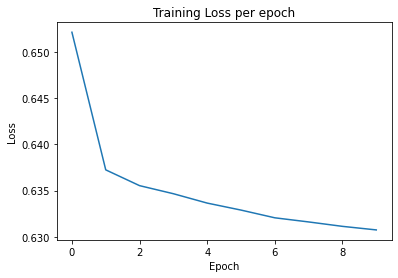

In [11]:
class CAE2(nn.Module):
    def __init__(self, channels, padding = 1, stride = 1, kernel = 3):
        super(CAE2, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels[0], kernel_size=kernel, padding=padding, stride=2)
        self.conv2 = nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=kernel, padding=padding, stride=2)
        self.conv3 = nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=kernel, padding=padding, stride=stride)
        self.maxpool = nn.MaxPool2d(kernel_size=kernel-1, stride=stride, padding=0)

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=channels[2], out_channels=channels[3], kernel_size=15, padding=padding, stride=stride)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=channels[3], out_channels=3, kernel_size=16, padding=padding, stride=stride)
        self.print_latent_shape = 0

    def forward(self, x):
        # encoder
        x1 = F.relu(self.conv1(x))

        x2 = self.maxpool(x1)
        x3 = F.relu(self.conv2(x2))
        x4 = self.maxpool(x3)
        x5 = F.relu(self.conv3(x4))
        if self.print_latent_shape == 0:
            print(str(x1.shape) + " -> ")
            print(str(x2.shape) + " -> ")
            print(str(x3.shape) + " -> ")
            print(str(x4.shape) + " -> ")
            print("Latent space shape: " + str(x5.shape))
            self.print_latent_shape +=1

        # decoder
        x6 = F.relu(self.t_conv1(x5))
        y = F.sigmoid(self.t_conv2(x6))
        return y


model = CAE2(channels=[5, 8, 10, 8]).to(device)

criterion = nn.BCELoss()  # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train(model, save=SAVE_PATH2)

torch.Size([64, 5, 16, 16]) -> 
torch.Size([64, 5, 15, 15]) -> 
torch.Size([64, 8, 8, 8]) -> 
torch.Size([64, 8, 7, 7]) -> 
Latent space shape: torch.Size([64, 10, 7, 7])
Test Loss =  0.629613829787234


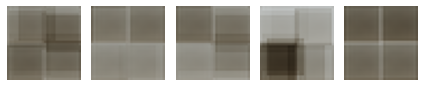

In [12]:
model = CAE2(channels=[5, 8, 10, 8])
model.load_state_dict(torch.load(SAVE_PATH2))
model.eval()
test(model)

# Sample outputs
output = model.forward(images)
output = output.detach().numpy()

ff2, axarr = plt.subplots(1, 5)
for i in range(5):
    axarr[i].imshow(np.transpose(output[i], (1, 2, 0)))
    axarr[i].axis('off')
plt.tight_layout()
plt.show()

Now the latent space has size 10 x 7 x 7 which is smaller compared to the previous configuration (16 x 30 x 30).
Consequently the reconstruction error is higher.

_Adapt your network from the previous part such that it learns to reconstruct colors by feeding in grayscale
images but predicting all RGB channels. As a starting point, use the hyperparameters (including the network
architecture) that you identified to yield the best performance in Exercise 3.2._

Let's first see what YUV channels look like, how to access Chrominance
and how to reconstruct back the RGB color by combining the grayscale image with Chrominance channel.

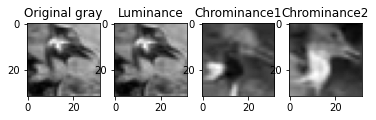

In [13]:
import cv2
images, labels = iter(test_loader).next()
img = images[50].numpy()
img = np.transpose(img, (1, 2, 0))
yuv_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.subplot(1,4,1)
plt.imshow(gray_image, cmap="gray")
plt.title('Original gray')
plt.subplot(1,4,2)
plt.imshow(yuv_image[:,:,0],cmap="gray")
plt.title('Luminance')
plt.subplot(1, 4, 3)
plt.imshow(yuv_image[:,:,1],cmap="gray")
plt.title('Chrominance1')
plt.subplot(1,4,4)
plt.imshow(yuv_image[:,:,2],cmap="gray")
plt.title('Chrominance2')
plt.show()

You can see that the grayscale and the luminance images are the same.
By combining the 2 chrominance channels with the luminance channel we can reconstruct
the original RGB image.

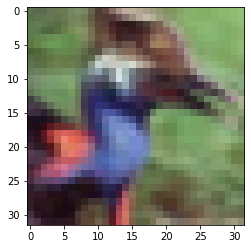

In [14]:
luminance_image = yuv_image[:,:,0]

chr_image = yuv_image[:,:,1:]
yuv_reconstructed = cv2.merge((luminance_image, chr_image[:,:,0], chr_image[:,:,1]))

rgb_image = cv2.cvtColor(yuv_reconstructed, cv2.COLOR_YUV2BGR)
plt.imshow(rgb_image)
plt.show()

Now the goal is to predict the 2D chrominance by using as input the 1D luminance.

In [15]:
class CAE_colorization(nn.Module):
    def __init__(self):
        super(CAE_colorization, self).__init__()

        channels = [8, 12, 16, 20, 16]

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels[0], kernel_size=(3, 3), padding=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=(3, 3), padding=1, stride=1)
        self.conv3 = nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=(3, 3), padding=1, stride=1)
        self.conv4 = nn.Conv2d(in_channels=channels[2], out_channels=channels[3], kernel_size=(3, 3), padding=1, stride=1)
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=1, padding=0)

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=channels[3], out_channels=channels[4], kernel_size=(4, 4), padding=1, stride=1)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=channels[4], out_channels=channels[1], kernel_size=(4, 4), padding=1, stride=1)
        self.t_conv3 = nn.ConvTranspose2d(in_channels=channels[1], out_channels=channels[0], kernel_size=(3, 3), padding=1, stride=1)
        self.t_conv4 = nn.ConvTranspose2d(in_channels=channels[0], out_channels=2, kernel_size=(3, 3), padding=1, stride=1)
        self.print_latent_shape = 0

    def forward(self, x):
        # encoder
        x1 = F.relu(self.conv1(x))

        x2 = self.maxpool(x1)
        x3 = F.relu(self.conv2(x2))
        x4 = self.maxpool(x3)
        x5 = F.relu(self.conv3(x4))
        x5 = F.relu(self.conv4(x5))

        if self.print_latent_shape == 0:
            print(str(x1.shape) + " -> ")
            print(str(x2.shape) + " -> ")
            print(str(x3.shape) + " -> ")
            print(str(x4.shape) + " -> ")
            print("Latent space shape = " + str(x5.shape))
            self.print_latent_shape +=1

        # decoder
        x6 = F.relu(self.t_conv1(x5))
        x6 = F.relu(self.t_conv2(x6))
        x6 = F.relu(self.t_conv3(x6))
        y = F.sigmoid(self.t_conv4(x6))

        if self.print_latent_shape == 0:
            print(str(x6.shape) + " -> " + str(y.shape))
            self.print_latent_shape +=1

        return y

In [16]:
model_colorization = CAE_colorization().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_colorization.parameters(), lr=LR)

Epoch 0, Loss = 0.6932959946595469
Epoch 1, Loss = 0.693294659546062
Epoch 2, Loss = 0.6932963951935919
Epoch 3, Loss = 0.6932921228304418
Epoch 4, Loss = 0.6932921228304407
Epoch 5, Loss = 0.6932946595460626
Epoch 6, Loss = 0.6932943925233654
Epoch 7, Loss = 0.693293724966623
Epoch 8, Loss = 0.6932974632843801
Epoch 9, Loss = 0.6932911882510024
Training finished


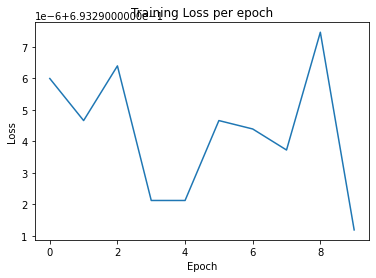

In [19]:
EPOCHS = 10
def train(model, save):
    loss_history = []
    running_loss = 0.0
    for i in range(EPOCHS):
        # TRAIN MODEL
        loss_sum = 0
        n = 0
        for j, data in enumerate(train_loader, 0):
            n = j
            # get the training data
            imgs, _ = data

            # rgb to yuv
            images_yuv = np.zeros((BATCH_SIZE, 32, 32, 3))
            for idx in range(BATCH_SIZE):
                img = imgs[idx].numpy()
                yuv_image = cv2.cvtColor(np.transpose(img, (1, 2, 0)), cv2.COLOR_BGR2YUV)
                images_yuv[idx] = yuv_image

            # numpy to tensor
            target = torch.tensor(np.reshape(images_yuv, (64, 3, 32, 32))[:, 1:, :, :]).float().to(device)
            images_yuv_tensor = torch.from_numpy(np.reshape(np.reshape(images_yuv, (64, 3, 32, 32))[:, 0, :, :], (64, 1, 32, 32))).to(device)  # luminance as input

            # Before the backward pass, set gradients to zero
            optimizer.zero_grad()

            # predict
            input = images_yuv_tensor.float().to(device)
            output = model.forward(input).to(device)  # chrominance
            # compute loss
            loss = criterion(output, target)
            loss_sum += round(float(loss.item()), 4)

            # backpropagate loss error
            loss.backward()

            # optimize with backprop
            optimizer.step()
            del data, imgs

        # region print current loss
        loss_epoch = loss_sum / n
        loss_history.append(loss_epoch)
        print("Epoch " + str(i) + ", Loss = " + str(loss_epoch))

    # SAVE THE MODEL
    torch.save(model.state_dict(), save)
    print("Training finished")

    # PLOT ACCURACY
    plt.plot(loss_history)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training Loss per epoch')
    plt.show()


train(model_colorization, SAVE_PATH3)

_Report on your results and reason about potential shortcomings of your network.
What aspects of the architecture/hyperparameters/optimization could be improved upon to fit the model more adequately to this
application? Try out some ideas._

In [20]:
images, _ = iter(test_loader).next()
images_plot = images.numpy()

#model = CAE_colorization(channels=[5, 12, 16, 12])
model_colorization.load_state_dict(torch.load(SAVE_PATH3))
model_colorization.eval()
model_colorization = model_colorization.to('cpu')
img = images[50].numpy()
img = np.transpose(img, (1, 2, 0))
yuv_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

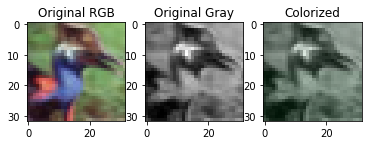

In [21]:
luminance_image = torch.tensor(np.reshape(yuv_image[:,:,0], (1, 1, 32, 32)))
#chr_image = yuv_image[:,:,1:]
chr_image = model_colorization.forward(luminance_image)
chr_image = np.reshape(chr_image.detach().numpy(), (32, 32, 2))
yuv_reconstructed = cv2.merge((yuv_image[:,:,0], chr_image[:,:,0], chr_image[:,:,1]))
reconstructed = cv2.cvtColor(yuv_reconstructed, cv2.COLOR_YUV2BGR)
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original RGB')
plt.subplot(1,3,2)
plt.imshow(yuv_image[:,:,0],cmap="gray")
plt.title('Original Gray')
plt.subplot(1, 3, 3)
plt.imshow(reconstructed)
plt.title('Colorized')
plt.show()

It is clear that the model needs improvement. The latent space size needs to be increased
in order to find a better mapping $f: X \rightarrow Y$. One way of doing this would be adding more
convolutional, pooling, upsampling and unpooling layers, where the goal would be increasing the width, height and channel sizes
at the latent space.